<a href="https://colab.research.google.com/github/sreeramdnair/Artificial-Neural-Networks/blob/main/Image_Morphing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [72]:
import os
from google.colab import files

def Upload_Images(**kwargs)-> str:
  uploaded = files.upload()
  image_type=kwargs.get("image_type")
  for k, v in uploaded.items():
    _, ext = os.path.splitext(k)
    os.remove(k)
    IMAGE_NAME = f"{image_type}{ext}"
    open(IMAGE_NAME, 'wb').write(v)
    return IMAGE_NAME

In [23]:
## Upload Source Image:
SOURCE_NAME=Upload_Images(image_type="source")

Saving sundar.jpg to sundar.jpg


In [15]:
## Upload target Image to be morphed to:
TARGET_NAME=Upload_Images(image_type="target")
TARGET_NAME

Saving elon_musk.jpg to elon_musk.jpg


'target.jpg'

In [7]:
!wget http://dlib.net/files/shape_predictor_5_face_landmarks.dat.bz2
!bzip2 -d shape_predictor_5_face_landmarks.dat.bz2

--2022-09-04 07:56:18--  http://dlib.net/files/shape_predictor_5_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5706710 (5.4M)
Saving to: ‘shape_predictor_5_face_landmarks.dat.bz2’

shape_predictor_5_f 100%[===================>]   5.44M  --.-KB/s    in 0.1s    

2022-09-04 07:56:18 (50.4 MB/s) - ‘shape_predictor_5_face_landmarks.dat.bz2’ saved [5706710/5706710]



In [73]:
import numpy as np
from matplotlib import pyplot as plt
import dlib
import cv2
from PIL import Image
import torch
import dnnlib
import legacy
import imageio
from tqdm.notebook import tqdm


In [59]:
def PreProcess(**kwargs)-> None:
  try:
    image_loc={
        "source":SOURCE_NAME,
        "target":TARGET_NAME
    }
    image_type = kwargs.get("image_type")
    image = cv2.imread(image_loc.get(image_type))
    if image is None:
        raise ValueError("Source image not found")
    cropped_image = Crop_image(image)
    img = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title(f'{image_type}')
    plt.show()

    cv2.imwrite(f"cropped_{image_type}.png", cropped_image)
  except Exception as e:
    print("ERROR! In preprocessing the image"+str(e))

In [60]:
def Crop_image(img):
  try:
    left_side, right_side = Detect_face(img)
    d = abs(right_side[0] - left_side[0])
    z = 255/d
    ar = img.shape[0]/img.shape[1]
    w = img.shape[1] * z
    img2 = cv2.resize(img, (int(w), int(w*ar)))
    bordersize = 1024
    img3 = cv2.copyMakeBorder(
        img2,
        top=bordersize,
        bottom=bordersize,
        left=bordersize,
        right=bordersize,
        borderType=cv2.BORDER_REPLICATE)

    left_side2, right_side2 = Detect_face(img3)

    crop1 = left_side2[0] - 385 
    crop0 = left_side2[1] - 490
    return img3[crop0:crop0+1024,crop1:crop1+1024]
  except Exception as e:
    print("ERROR! In cropping the image"+str(e))

In [61]:
def Detect_face(img):
  try:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    scaled = detector(gray, 0)
    shape = predictor(gray, scaled[0])
    features = []
    features=[(i, (shape.part(i).x, shape.part(i).y)) for i in range(0, 5) ]

    return (int(features[3][1][0] + features[2][1][0]) // 2, \
      int(features[3][1][1] + features[2][1][1]) // 2), \
      (int(features[1][1][0] + features[0][1][0]) // 2, \
      int(features[1][1][1] + features[0][1][1]) // 2)
  except Exception as e:
    print("ERROR! in Detecting the face"+str(e))

In [18]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_5_face_landmarks.dat')

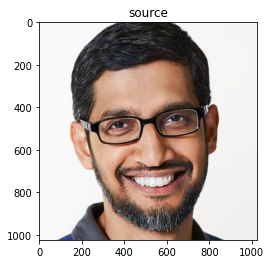

In [62]:
## PreProcessing the input Image
PreProcess(image_type="source")

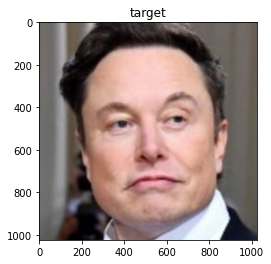

In [63]:
## PreProcessing the target Image
PreProcess(image_type="target")

In [64]:
FFHQ_MODEL = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"
STEPS = 150
FPS = 30
FREEZE_STEPS = 30

cmd = f"python /content/stylegan2-ada-pytorch/projector.py --save-video 0 --num-steps 1000 --outdir=out_source --target=cropped_source.png --network={FFHQ_MODEL}"
!{cmd}

Loading networks from "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"...
Computing W midpoint and stddev using 10000 samples...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %105 : int = prim::profile_ivalue(%103)
 does not have profile information (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  return forward_call(*input, **kwargs)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1130: UserWarning: concrete shape for bias input is required to decompose into conv + bias (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:2233.)
  return forward_call(*input, **kwargs)
step    1/1000: dist 0.61 loss 24567.28
step    2/1000: dist 0.63 loss 27640.61
step    3/1000: dist 0.66 loss 27166.77
step    4/1000: dist 0.54 loss 26253

In [66]:
cmd = f"python /content/stylegan2-ada-pytorch/projector.py --save-video 0 --num-steps 1000 --outdir=out_target --target=cropped_target.png --network={FFHQ_MODEL}"
!{cmd}

Loading networks from "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"...
Computing W midpoint and stddev using 10000 samples...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %105 : int = prim::profile_ivalue(%103)
 does not have profile information (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  return forward_call(*input, **kwargs)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1130: UserWarning: concrete shape for bias input is required to decompose into conv + bias (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:2233.)
  return forward_call(*input, **kwargs)
step    1/1000: dist 0.57 loss 24567.23
step    2/1000: dist 0.67 loss 27640.64
step    3/1000: dist 0.66 loss 27166.78
step    4/1000: dist 0.48 loss 26253

In [67]:
## getting images which are close to input Images in Gan Space
def Get_GanImages(**kwargs):
  image_type=kwargs.get("image_type")
  img_gan_source = cv2.imread(f'/content/out_{image_type}/proj.png')
  img = cv2.cvtColor(img_gan_source, cv2.COLOR_BGR2RGB)
  plt.imshow(img)
  plt.title('{image_type}')
  plt.show()

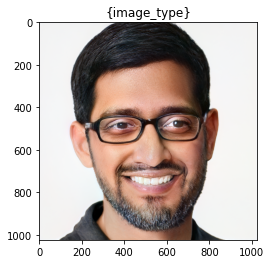

In [69]:
# source image in Pretrained GAN space
Get_GanImages(image_type="source")

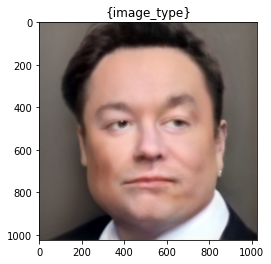

In [70]:
# target image in Pretrained GAN space
Get_GanImages(image_type="target")

In [75]:
def Generate_morphs(**kwargs)-> None:
  try:
    lvec1 = np.load(f'/content/{kwargs.get("source")}/projected_w.npz')['w']
    lvec2 = np.load(f'/content/{kwargs.get("target")}/projected_w.npz')['w']

    network_pkl = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"
    device = torch.device('cuda')
    with dnnlib.util.open_url(network_pkl) as fp:
        G = legacy.load_network_pkl(fp)['G_ema'].requires_grad_(False).to(device) # type: ignore

    diff = lvec2 - lvec1
    step = diff / STEPS
    current = lvec1.copy()
    target_uint8 = np.array([1024,1024,3], dtype=np.uint8)
    final_name=kwargs.get("output_name")

    video = imageio.get_writer(f'/content/{final_name}.mp4', mode='I', fps=FPS, codec='libx264', bitrate='16M')

    for j in tqdm(range(STEPS)):
      z = torch.from_numpy(current).to(device)
      synth_image = G.synthesis(z, noise_mode='const')
      synth_image = (synth_image + 1) * (255/2)
      synth_image = synth_image.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()

      repeat = FREEZE_STEPS if j==0 or j==(STEPS-1) else 1
      
      for i in range(repeat):
        video.append_data(synth_image)
      current = current + step


    video.close()
    files.download(f"{final_name}.mp4")
  except Exception as e:
    print("ERROR! In Generating the morphs"+str(e))

In [78]:
Generate_morphs(source="out_source",target="out_target",output_name="sundar_elon")

  0%|          | 0/150 [00:00<?, ?it/s]

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>